In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns
from itertools import combinations # for AIC selection
from sklearn import metrics

In [3]:
df = pd.read_csv("./ufc.csv")
df = pd.DataFrame(df)
df

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith
7413,"Denver, Colorado, USA",Frank Hamaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Morris
7414,"Denver, Colorado, USA",Johnny Rhodes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7415,"Denver, Colorado, USA",Patrick Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our dataframe contains some null rows, so will need to remove it. Additionally column with "Time" doesn't useful for our aims in this represantation. We need to convert it to another units (to seconds).

In [4]:
df = df.dropna()
df_with_time = df.copy()

def time_converter(time: str) -> int:
    """
    The time is given in the following pattern "minutes:seconds"
    and converted to time in seconds
    """
    first, second = time.split(":")

    return int(first) * 60 + int(second)

def round_converter(rnd: str) -> int:
    """
    Convert the round amounts into time in seconds
    """
    return (rnd-1) * 300

df_with_time["Seconds"] = df_with_time["Time"].apply(time_converter) + df_with_time["Round"].apply(round_converter)

df_with_time


,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan,64.0
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner,169.0
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo,900.0
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady,703.0
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0


Also some there are some "strange" fights: fighter 1 and fighter 2 both loss in fight.

In [5]:
df_with_time.tail(10)

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
7403,"Denver, Colorado, USA",Royce Gracie,Fred Ettish,1.0,0.0,13.0,4.0,0.0,0.0,1.0,0.0,Open Weight,SUB Bulldog Choke,1.0,3:07,UFC 2,11-Mar-94,Remco Pardoel,187.0
7404,"Denver, Colorado, USA",Patrick Smith,Scott Morris,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,Open Weight,KO/TKO Elbows,1.0,0:30,UFC 2,11-Mar-94,Johnny Rhodes,30.0
7405,"Denver, Colorado, USA",Royce Gracie,Minoki Ichihara,0.0,0.0,2.0,3.0,1.0,0.0,2.0,0.0,Open Weight,SUB Armbar,1.0,5:08,UFC 2,11-Mar-94,Patrick Smith,308.0
7406,"Denver, Colorado, USA",Remco Pardoel,Scott Baker,0.0,0.0,3.0,0.0,0.0,1.0,5.0,0.0,Open Weight,SUB Triangle Choke,1.0,6:41,UFC 2,11-Mar-94,Royce Gracie,401.0
7407,"Denver, Colorado, USA",Johnny Rhodes,Alberta Cerra Leon,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,Open Weight,SUB Ezekiel Choke,1.0,9:51,UFC 2,11-Mar-94,Jason DeLucia,591.0
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith,20.0


We need to remove it

In [6]:
df_with_time = df_with_time.loc[
    (df_with_time["Fighter 1"] == df_with_time["Winner"]) | 
    (df_with_time["Fighter 1"] == df_with_time["Winner"])].reset_index(drop=True)

Next, let us show average statistic per fight (including first and second fighter)

In [7]:
total_kd = (df["Fighter_1_KD"] + df["Fighter_2_KD"]).mean()
total_str= (df["Fighter_1_STR"] + df["Fighter_2_STR"]).mean()
total_td= (df["Fighter_1_TD"] + df["Fighter_2_TD"]).mean()
total_sub= (df["Fighter_1_SUB"] + df["Fighter_1_SUB"]).mean()

print("Average knockdowns per fight: ", total_kd)
print("Average significant strikes per fight: ", total_str)
print("Average takedown attemps per fight: ", total_td)
print("Average submissions attemps per fight: ", total_sub)

Average knockdowns per fight:  0.4305180787911495
Average significant strikes per fight:  71.68497031840259
Average takedown attemps per fight:  2.1184565569347007
Average submissions attemps per fight:  1.0642201834862386


In [8]:
arman = df.loc[(df["Fighter 2"] == "Arman Tsarukyan")]
arman2 = df.loc[(df["Fighter 1"] == "Arman Tsarukyan")]
# arman["Fighter_1_KD"].mean()
round((arman["Fighter_2_KD"].mean() + arman2["Fighter_1_KD"].mean())/2, 2)



0.38

As we can see knockdowns is the rarest fight moment. Now let us look what type of finishes UFC fight can have:

In [9]:
methods = df_with_time["Method"].unique()

methods

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'Overturned', 'KO/TKO Elbows',
       'KO/TKO Kick', 'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC',
       'SUB Arm Triangle', 'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'DQ',
       'SUB Anaconda Choke', 'SUB Ezekiel Choke', 'SUB Triangle Choke',
       'SUB Twister', 'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'Overturned Guillotine Choke',
       'KO/TKO Elbow', 'SUB Other - Lock', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'Overturned Punches',
       'SUB Ankle Lock', 'SUB Forearm Choke', 'SUB Injury',
       'Overturned Punch', 'Overturned Rear Naked Choke',
       'Overturned Knee', 'O

There are lots of different type of finishes, but all them come down to KO/TKO, SUB, DEC, CNC. Overturned, Other and DQ are useless characteristic for our research.

In [10]:
def methods_destroyer(df: pd.DataFrame) -> pd.DataFrame:
    filtered = df[~df["Method"].str.contains("Overturned|DQ|Other")]
    return filtered


df_fil = methods_destroyer(df_with_time)

df_fil["Method"].unique()

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'KO/TKO Elbows', 'KO/TKO Kick',
       'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC', 'SUB Arm Triangle',
       'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'SUB Anaconda Choke',
       'SUB Ezekiel Choke', 'SUB Triangle Choke', 'SUB Twister',
       'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'KO/TKO Elbow', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'SUB Ankle Lock',
       'SUB Forearm Choke', 'SUB Injury', 'SUB Peruvian Necktie',
       'SUB Schultz Front Headlock', 'SUB Bulldog Choke',
       'SUB Suloev Stretch', 'SUB Omoplata', 'SUB Calf Slicer',
       'SUB North-South Choke', 'SUB Pac

Now this data can be useful, we can plot distribution of methods if we remove additional information, like "Armbar", "Punch" and so on.

In [11]:
def replace_method(method: str) -> str:
    """
    Makes type of fight finishes more generic
    """
    if "DEC" in method:
        return "DEC"
    elif "SUB" in method:
        return "SUB"
    elif "KO" in method or "CNC" in method:
        return "KO/TKO"

df_methods = df_fil.copy()
df_methods["Method"] = df_fil["Method"].apply(replace_method)
df_methods["Method"].unique()

array(['KO/TKO', 'DEC', 'SUB'], dtype=object)

Now we can plot histogram of distribtuion

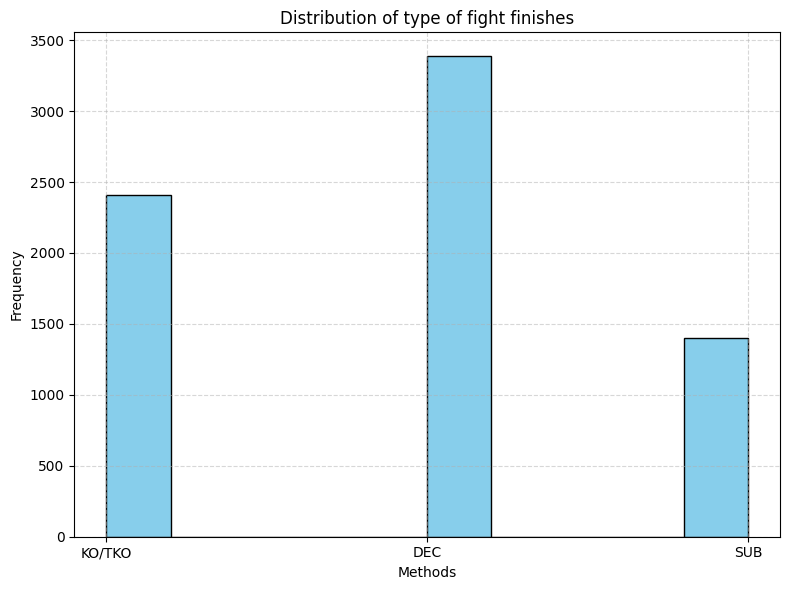

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(df_methods["Method"], color='skyblue', edgecolor='black')
plt.title('Distribution of type of fight finishes')
plt.xlabel('Methods')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Now let us take a look at "Weight_Class".

In [13]:
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       'Catch Weight', "Women's Featherweight", 'Super Heavyweight',
       'Open Weight'], dtype=object)

Some of these categories are not used in UFC, so we will drop them 

In [14]:
def weight_destroyer(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove all outdated values
    """
    filtered = df[~df["Weight_Class"].str.contains("Open|Catch|Super")]
    return filtered

df_fil = weight_destroyer(df_fil)
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       "Women's Featherweight"], dtype=object)

Now, we are going to remove all unneccassary columns: Date (data doesn't depend on date), Event Name, Round, Time, Location.

In [15]:
def de_remover(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes unneccassary columns
    """
    if df.columns.str.contains("Date|Event Name|Round|Time|Location").any():
        return df.drop(["Date", "Event Name", "Round", "Time", "Location"], axis=1)
    

df_fil = de_remover(df_fil)

Finally, our dataframe is ready to be used in project. But before, we will run logit and OLS models, let us create dataframe with fighters statistic.

In [16]:
fighters = list(set(df_fil["Fighter 1"].unique()).union(set(df_fil["Fighter 2"].unique())))
fighters_df = pd.DataFrame({"Fighter_name": [],
                            "Average_significant_strikes": [],
                            "Average_takedowns": [],
                            "Average_submission_attempts": [],
                            "Average_knockdowns": [],
                            "Average_activity": [],
                            "Wins": [],
                            "Loss": [],
                            "Winrate": []})


for ele in fighters:
    win_df = df_fil.loc[df_fil["Fighter 1"] == ele]
    lose_df = df_fil.loc[df_fil["Fighter 2"] == ele]

    wins, losses = int(len(win_df.index)), int(len(lose_df.index))

    amount_of_mentions = wins + losses

    avg_strk = round((win_df["Fighter_1_STR"].sum() + lose_df["Fighter_2_STR"].sum())/amount_of_mentions, 2)
    avg_tkd = round((win_df["Fighter_1_TD"].sum() + lose_df["Fighter_2_TD"].sum())/amount_of_mentions, 2)
    avg_subs = round((win_df["Fighter_1_SUB"].sum() + lose_df["Fighter_2_SUB"].sum())/amount_of_mentions, 2)
    avg_kd = round((win_df["Fighter_1_KD"].sum() + lose_df["Fighter_2_KD"].sum())/amount_of_mentions, 2)
    avg_act = avg_strk + avg_tkd + avg_subs + avg_kd

    data = {
        "Fighter_name": [ele],
        "Average_significant_strikes": [avg_strk],
        "Average_takedowns": [avg_tkd],
        "Average_submission_attempts": [avg_subs],
        "Average_knockdowns": [avg_kd],
        "Average_activity": [avg_act],
        "Wins": [wins],
        "Loss": [losses],
        "Winrate": [round(wins/(wins+losses), 2)]
    }

    fighters_df = pd.concat([fighters_df, pd.DataFrame(data)], ignore_index = True)

fighters_df

,Fighter_name,Average_significant_strikes,Average_takedowns,Average_submission_attempts,Average_knockdowns,Average_activity,Wins,Loss,Winrate
0,Molly McCann,61.09,1.18,0.36,0.18,62.81,6.0,5.0,0.55
1,Trevor Prangley,27.75,3.50,1.00,0.00,32.25,2.0,2.0,0.50
2,Guilherme Vasconcelos,49.00,0.00,0.00,0.00,49.00,0.0,1.0,0.00
3,Teruto Ishihara,32.78,0.33,0.00,0.89,34.00,3.0,6.0,0.33
4,Russell Doane,17.12,1.38,0.50,0.25,19.25,3.0,5.0,0.38
...,...,...,...,...,...,...,...,...,...
2309,Yaotzin Meza,18.17,0.83,1.33,0.00,20.33,2.0,4.0,0.33
2310,Amir Sadollah,56.45,0.45,0.27,0.00,57.17,6.0,5.0,0.55
2311,Rich Franklin,39.88,0.71,0.12,0.59,41.30,12.0,5.0,0.71
2312,David Branch,15.22,1.56,0.00,0.11,16.89,4.0,5.0,0.44


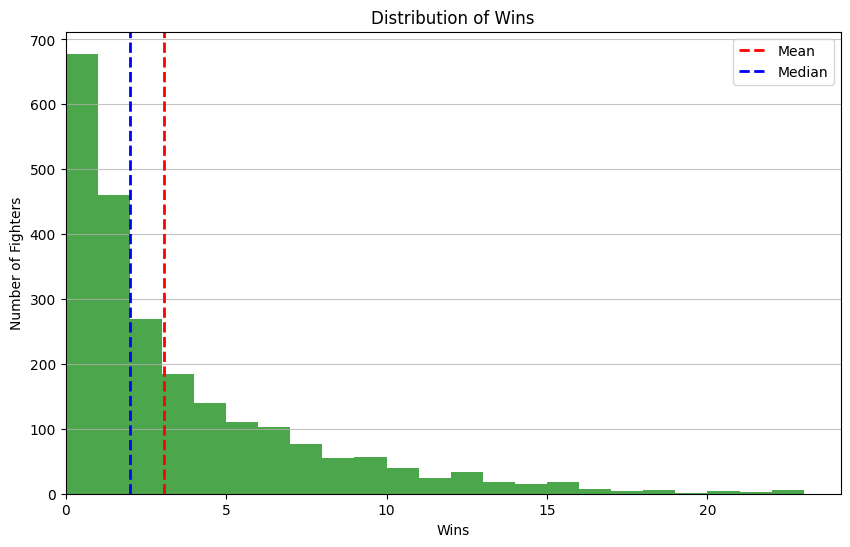

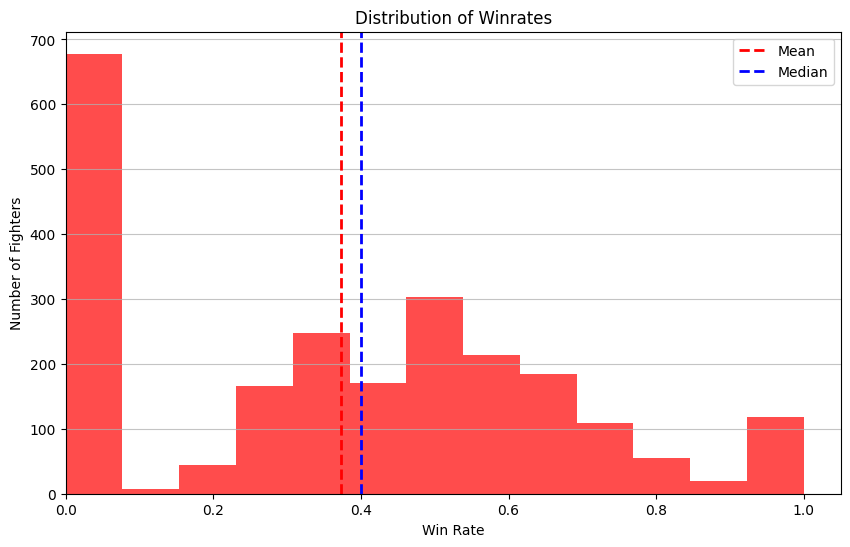

In [17]:
mean_wins = fighters_df["Wins"].mean()
median_wins = fighters_df["Wins"].median()

plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Wins"], bins=int(fighters_df["Wins"].max()), color='green', alpha=0.7)
plt.title('Distribution of Wins')
plt.xlabel('Wins')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wins, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wins, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()

plt.show()

mean_wr = fighters_df["Winrate"].mean()
median_wr = fighters_df["Winrate"].median()
plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Winrate"], bins='auto', color='red', alpha=0.7)
plt.title('Distribution of Winrates')
plt.xlabel('Win Rate')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wr, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wr, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()
plt.show()

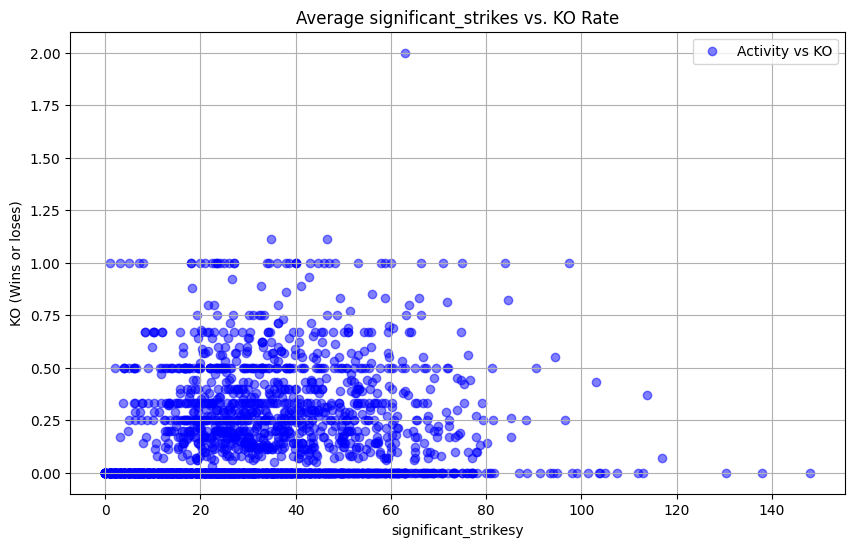

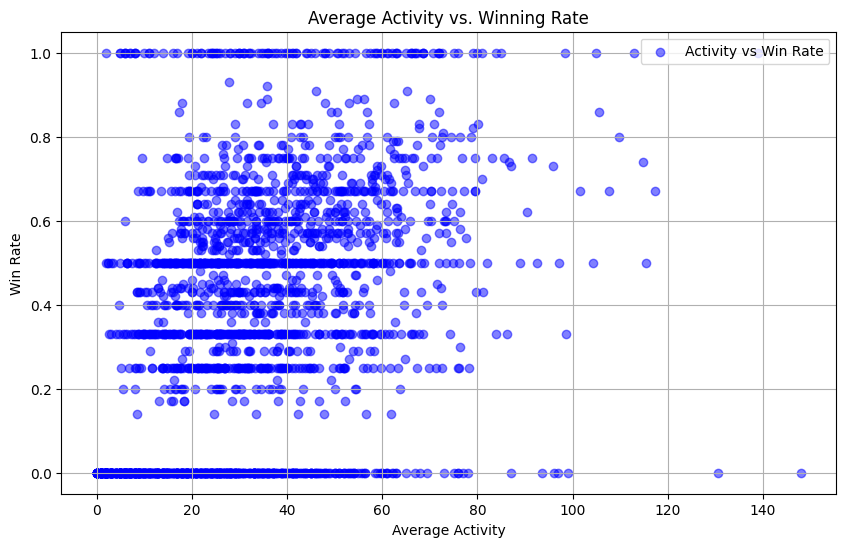

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_significant_strikes"], fighters_df["Average_knockdowns"], color='blue', alpha=0.5, label='Activity vs KO')
plt.title('Average significant_strikes vs. KO Rate')
plt.xlabel('significant_strikesy')
plt.ylabel('KO (Wins or loses)')
plt.legend()
plt.grid(True)
plt.show()

# Improved Scatter plot for Average Activity vs. Win Rate
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_activity"], fighters_df["Winrate"], color='blue', alpha=0.5, label='Activity vs Win Rate')
plt.title('Average Activity vs. Winning Rate')
plt.xlabel('Average Activity')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)
plt.show()

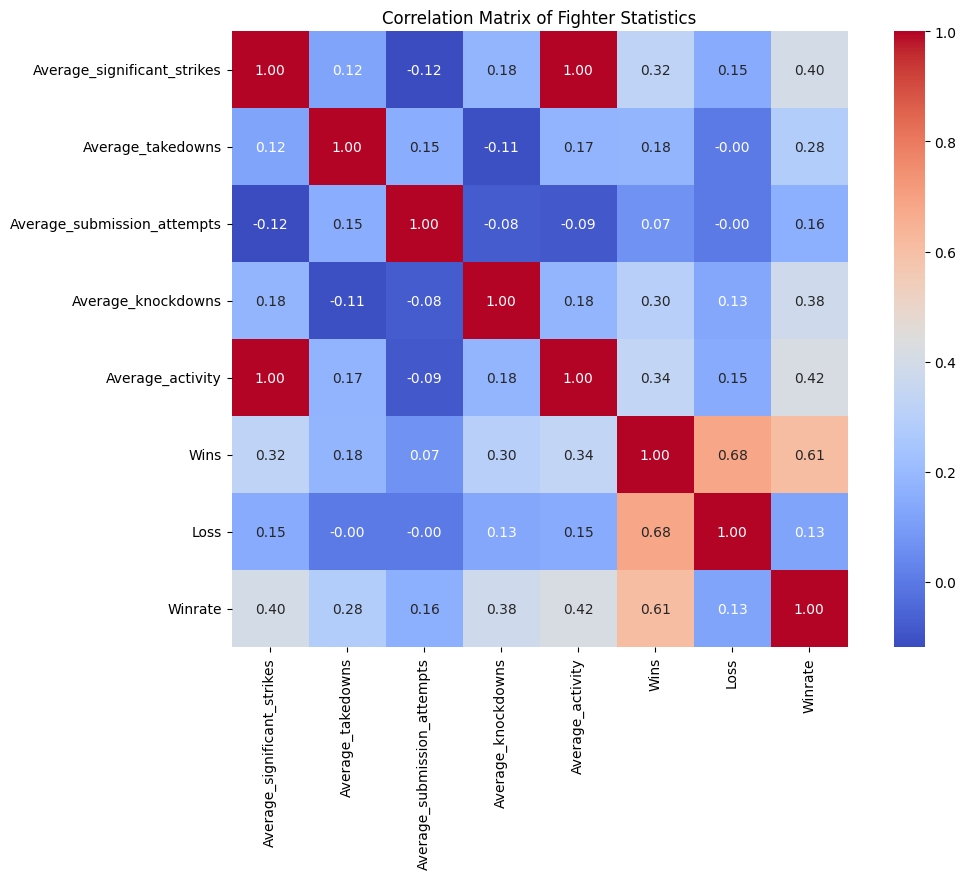

In [19]:
cor_df = fighters_df.drop(["Fighter_name"], axis=1)
correlation_matrix = cor_df.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title('Correlation Matrix of Fighter Statistics')
plt.show()

# OLS

Now, we are going to construct OLS method for predicting the duration of fight in seconds. However, our dataframe contains male and female fighters and it is not relevant to predict duration fight in combined dataframe, because man and woman can not have much up in UFC, so we are going to divide dataframe in two: for males and for females

In [20]:
df_fil["Gender"] = np.where(df_fil["Weight_Class"].str.contains("Women"), 1, 0)
df_man = df_fil.loc[df_fil["Gender"] == 0].drop(["Gender"], axis=1).reset_index(drop=True)
df_woman = df_fil.loc[df_fil["Gender"] != 0].drop(["Gender"], axis=1).reset_index(drop=True)

Variables in "Weight_Class" is ordinal, so to make our future OLS more relevent, we need to divide this column to many distinct columns. Each this column will represent the distinct weight category, so if fighters belong to this category we will put 1, if not 0 (It is clear that fighters in one fight can only belongs to one category).

In [21]:
def weight_breaker(df: pd.DataFrame) -> pd.DataFrame:
    """
    Breakes Weight_Class category to 
    on columns that display separate weight categories
    """
    for ele in df["Weight_Class"].unique():
        df[ele] = np.where(df["Weight_Class"].str.contains(ele), 1, 0)

    return df if not df.columns.str.contains("Weight_Class").any() else df.drop(['Weight_Class'], axis=1)

df_man_clear = weight_breaker(df_man)
df_woman_clear = weight_breaker(df_woman)

df_man_clear

,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Winner,Seconds,Lightweight,Bantamweight,Welterweight,Middleweight,Light Heavyweight,Featherweight,Heavyweight,Flyweight
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,Arman Tsarukyan,64.0,1,0,0,0,0,0,0,0
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,Jalin Turner,169.0,1,0,0,0,0,0,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,Deiveson Figueiredo,900.0,0,1,0,0,0,0,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,Sean Brady,703.0,0,0,1,0,0,0,0,0
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,Joaquim Silva,900.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6399,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,Dan Henderson,480.0,0,0,0,1,0,0,0,0
6400,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,David Abbott,43.0,0,0,0,0,0,0,1,0
6401,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,Mike van Arsdale,661.0,0,0,0,0,0,0,1,0
6402,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,Carlos Newton,52.0,0,0,0,1,0,0,0,0


In [22]:
def history_winrate(df: pd.DataFrame):
    nrows = df.size//df.columns.size
    winrate = []

    for i in range(nrows):
        current = df.iloc[i,]

        for j in range(1,3):
            current_fighter = current[f"Fighter {j}"]

            stats = pd.concat([df.iloc[i+1:,].loc[df[f"Fighter {k}"] == current_fighter] for k in range(1,3)])

            if stats.empty:
                current_winrate = 0

            else:
                wins = 0 if stats.loc[stats["Winner"] == current_fighter].empty else (stats["Winner"].value_counts())[current_fighter]
                all_fights = len(stats.index)

                current_winrate = 1 if not (wins - all_fights) else round(wins/all_fights, 2)
            
            winrate += [current_winrate]

    winrate = np.array(winrate)
    winrate2d = winrate.reshape(nrows, 2)
    
    winrate_df = pd.DataFrame({"Current winrate F1": winrate2d[:, 0], "Current winrate F2": winrate2d[:, 1]})

    res = pd.concat([df, winrate_df], axis=1, ignore_index=True)
    res.columns = df.columns.to_list() + winrate_df.columns.to_list()
    
    return res


winrates_df = history_winrate(df_man_clear)

In [23]:
names = [ele.replace(" ", "_") for ele in winrates_df.columns.to_list()]
winrates_df.columns = names

winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Lightweight,Bantamweight,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.78,0.77
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.59
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0.79,0.67
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,0,0,1,0,0,0,0,0,0.83,0.60
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6399,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,0,0,1,0,0,0,0,1.00,1.00
6400,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6401,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6402,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,0,0,1,0,0,0,0,0.00,0.00


In [24]:
def swapper(df: pd.DataFrame, to_swap: list[tuple]):
    nrows = df.shape[0]

    def swap(df: pd.DataFrame, index: int, category_1: str, category_2: str):
        temp = df.loc[index, category_1]
        df.loc[index, category_1] = df.loc[index, category_2]
        df.loc[index, category_2] = temp

    for i in range(nrows):
        decision = random.random()

        if decision > 0.5:
            for ele in to_swap:
                swap(df, i, ele[0], ele[1])

            df.loc[i, "Winner"] = 0
        else:
            df.loc[i, "Winner"] = 1
        

categories_all = [ele for ele in winrates_df.columns if "Fighter" in ele or "winrate" in ele]
categories = [(categories_all[i], categories_all[i+1]) for i in range(0, len(categories_all), 2)]

swapper(winrates_df, categories)



We have lots of zeroes in this dataframe so let us try to remove them or make more meaningful

In [25]:
winrates_df['Winrate_1_is_0'] = np.where(winrates_df["Current_winrate_F1"] == 0, 1, 0)
winrates_df['Winrate_2_is_0'] = np.where(winrates_df["Current_winrate_F2"] == 0, 1, 0)

In [26]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.78,0.77,0,0
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.56,0.59,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.79,0.67,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,1,0,0,0,0,0,0.83,0.60,0,0
4,Clay Guida,Joaquim Silva,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0.51,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6399,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6400,Hugo Duarte,David Abbott,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6401,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6402,Bob Gilstrap,Carlos Newton,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# OLS

In [27]:
model_Time=smf.ols(f"Seconds ~ {' + '.join(winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=winrates_df)
print(model_Time.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     646.0
Date:                Sat, 13 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:14:11   Log-Likelihood:                -43383.
No. Observations:                6404   AIC:                         8.681e+04
Df Residuals:                    6384   BIC:                         8.694e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            113.1946     15

Now It is seem that weight class in unsignificant variable, so let test their joint significance

In [28]:
weights = winrates_df[['Bantamweight', 'Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight']]

test_model = smf.ols(formula=f"Seconds ~ {' + '.join(weights.columns)}", data=winrates_df).fit()

f_statistic = test_model.fvalue
p_value = test_model.f_pvalue


if p_value < 0.05:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


It seems their are significant. Now let perform model selection with AIC to create the best model

In [29]:
# UNDER CONSTRUCTION

# aic_df = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Weight_Class', 'Method', 'Seconds', 'Lightweight'],axis=1)

# testing_df = aic_df.copy()

# best = aic_df.copy()
# best_model = smf.ols(f"Seconds ~ {' + '.join(best)}", data=winrates_df).fit()
# best_aic = best_model.aic

# for i in range(aic_df.columns.size):
#     for j in range(aic_df.columns.size):
#         testing_df = best.drop(best.columns[j], axis=1)

#         testing_model = smf.ols(f"Seconds ~ {' + '.join(testing_df)}", data=winrates_df).fit()

#         if testing_model.aic < best_aic:
#             best = testing_df.copy()
#             best_aic = testing_model.aic

# best



Let us calculate accuracy score for OLS model. To do it, we will need to convert preditions of variable "Second" into ordinal variable "Round" (the same we will need to perform with true values, because column "Round" was dropped at the beginning of research), however accuracy score is bad in distinguish between different classes so we will use f1 score for this purposes

In [30]:
predictor_data = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1)

predictions = model_Time.fit().predict(predictor_data)

print(predictions)

0       228.078010
1       355.878186
2       841.179561
3       726.198058
4       840.676533
           ...    
6399    690.338598
6400    286.764314
6401    404.367401
6402    307.749918
6403    458.637412
Length: 6404, dtype: float64


In [31]:
accuracy_win = winrates_df.copy()

def second_to_round(time: int) -> int:
    """
    Convert time to round
    """
    return math.ceil(time/360)

accuracy_win["Second_Pred"] = predictions
accuracy_win["Round_Pred"] = accuracy_win["Second_Pred"].apply(second_to_round)
accuracy_win["Round"] = accuracy_win["Seconds"].apply(second_to_round)

conf_mat = metrics.confusion_matrix(accuracy_win["Round"], accuracy_win["Round_Pred"])
f_1_score = metrics.f1_score(accuracy_win["Round"], accuracy_win["Round_Pred"], average="macro")

pred_accuracy = (accuracy_win["Round_Pred"] == accuracy_win["Round"]).value_counts()

print(f"Accuracy: {round(pred_accuracy[0]/(pred_accuracy[0]+pred_accuracy[1]),2)}")

Accuracy: 0.61


In [32]:
winrates_df["Winner"] = pd.to_numeric(winrates_df["Winner"])

In [33]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.78,0.77,0,0
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.56,0.59,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.79,0.67,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,1,0,0,0,0,0,0.83,0.60,0,0
4,Clay Guida,Joaquim Silva,0.0,0.0,43.0,46.0,2.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0.51,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6399,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6400,Hugo Duarte,David Abbott,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6401,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6402,Bob Gilstrap,Carlos Newton,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# Logit

In [34]:
model_logit=smf.logit(f"Winner ~ {' + '.join(winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=winrates_df)
print(model_logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.336222
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6404
Model:                          Logit   Df Residuals:                     6384
Method:                           MLE   Df Model:                           19
Date:                Sat, 13 Apr 2024   Pseudo R-squ.:                  0.5146
Time:                        14:14:11   Log-Likelihood:                -2153.2
converged:                       True   LL-Null:                       -4436.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.3591      0.229     -1.568      0.117      -0.808       0.090
Fight

Let's calculate the accuracy score for logit model

In [35]:
predictor_data_logit = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1)

predictions_logit = model_logit.fit().predict(predictor_data_logit)

Optimization terminated successfully.
         Current function value: 0.336222
         Iterations 7


Calculate the accuracy score for logit model

In [36]:
predictions_logit = np.where(predictions_logit > 0.5, 1, 0)

tp_and_fp = (winrates_df["Winner"] == predictions_logit).value_counts()

print(f"The accuracy score fot logit model: {(tp_and_fp[0]/(tp_and_fp[0]+tp_and_fp[1]))}")

The accuracy score fot logit model: 0.8703935040599625


In [37]:
metrics.f1_score(winrates_df['Winner'], predictions_logit)

0.8658694246929541

In [38]:
history_avg = winrates_df.copy()

def replace_stats_with_avg(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(df.index.stop):
        for j in range(1, 3):
            current = df.iloc[i]

            fighter = current[f"Fighter_{j}"]

            fighter_1_df = history_avg.iloc[i+1:].loc[(history_avg["Fighter_1"] == fighter)].reset_index(drop=True)
            fighter_2_df = history_avg.iloc[i+1:].loc[(history_avg["Fighter_2"] == fighter)].reset_index(drop=True)

            if fighter_1_df.empty and fighter_2_df.empty:
                avg_kd = 0
                avg_strk = 0
                avg_tkd = 0
                avg_subs = 0
            elif fighter_1_df.empty and (not fighter_2_df.empty): 
                avg_kd = fighter_2_df["Fighter_2_KD"].mean()
                avg_strk = fighter_2_df["Fighter_2_STR"].mean()
                avg_tkd = fighter_2_df["Fighter_2_TD"].mean()
                avg_subs = fighter_2_df["Fighter_2_SUB"].mean()
            elif fighter_2_df.empty and (not fighter_1_df.empty): 
                avg_kd = fighter_1_df["Fighter_1_KD"].mean()
                avg_strk = fighter_1_df["Fighter_1_STR"].mean()
                avg_tkd = fighter_1_df["Fighter_1_TD"].mean()
                avg_subs = fighter_1_df["Fighter_1_SUB"].mean()
            else:
                avg_kd = (fighter_1_df["Fighter_1_KD"].sum() + fighter_2_df["Fighter_2_KD"].sum()) / (fighter_1_df.shape[0] + fighter_2_df.shape[0])
                avg_strk = (fighter_1_df["Fighter_1_STR"].sum() + fighter_2_df["Fighter_2_STR"].sum()) / (fighter_1_df.shape[0] + fighter_2_df.shape[0])
                avg_tkd = (fighter_1_df["Fighter_1_TD"].sum() + fighter_2_df["Fighter_2_TD"].sum()) / (fighter_1_df.shape[0] + fighter_2_df.shape[0])
                avg_subs = (fighter_1_df["Fighter_1_SUB"].sum() + fighter_2_df["Fighter_2_SUB"].sum()) / (fighter_1_df.shape[0] + fighter_2_df.shape[0])

            df.loc[i, f"Fighter_{j}_KD"] = round(avg_kd, 2)
            df.loc[i, f"Fighter_{j}_STR"] = round(avg_strk, 2)
            df.loc[i, f"Fighter_{j}_TD"] = round(avg_tkd, 2)
            df.loc[i, f"Fighter_{j}_SUB"] = round(avg_subs, 2)

replace_stats_with_avg(history_avg)

history_avg

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,0.22,0.32,52.00,35.09,3.11,1.18,0.00,0.55,...,0,0,0,0,0,0,0.78,0.77,0,0
1,Jalin Turner,Bobby Green,0.33,0.18,38.89,74.73,0.33,0.91,0.67,0.23,...,0,0,0,0,0,0,0.56,0.59,0,0
2,Deiveson Figueiredo,Rob Font,0.79,0.47,36.86,76.73,1.14,0.80,1.43,0.33,...,0,0,0,0,0,0,0.79,0.67,0,0
3,Sean Brady,Kelvin Gastelum,0.17,0.35,52.17,50.70,2.33,0.95,0.67,0.10,...,1,0,0,0,0,0,0.83,0.60,0,0
4,Clay Guida,Joaquim Silva,0.17,0.22,31.66,35.44,2.17,0.11,0.46,0.33,...,0,0,0,0,0,0,0.51,0.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6399,Dan Henderson,Carlos Newton,1.00,0.00,31.00,1.00,1.00,1.00,1.00,3.00,...,0,1,0,0,0,0,1.00,1.00,0,0
6400,Hugo Duarte,David Abbott,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6401,Mike van Arsdale,Joe Pardo,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6402,Bob Gilstrap,Carlos Newton,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,1,0,0,0,0,0.00,0.00,1,1


Run new logit model for history_avg dataframe

In [39]:
model_logit2=smf.logit(f"Winner ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_logit2.fit().summary())

Optimization terminated successfully.
         Current function value: 0.672177
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6404
Model:                          Logit   Df Residuals:                     6384
Method:                           MLE   Df Model:                           19
Date:                Sat, 13 Apr 2024   Pseudo R-squ.:                 0.02962
Time:                        14:14:23   Log-Likelihood:                -4304.6
converged:                       True   LL-Null:                       -4436.0
Covariance Type:            nonrobust   LLR p-value:                 7.713e-45
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1119      0.159     -0.704      0.482      -0.424       0.200
Fight

In [40]:
model_Time2=smf.ols(f"Seconds ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_Time2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     20.05
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           5.97e-67
Time:                        14:14:23   Log-Likelihood:                -46631.
No. Observations:                6404   AIC:                         9.330e+04
Df Residuals:                    6384   BIC:                         9.344e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            430.4784     27

# Some additional functions to work with dataframe

In [68]:
def fighter_wrapper(func):
    """
    Wrapper for getting info
    """

    def wrapper(df: pd.DataFrame, name: str) -> pd.Series | pd.DataFrame:
        """
        Get fighter info from the dataframe
        """
        section = func()
        return df.loc[(df[section] == name).any(axis=1)]
    
    return wrapper

@fighter_wrapper
def get_stats_of_fighter() -> list[str]:
    """
    Returns the statistic of fighter
    """
    return ["Fighter_name"]

@fighter_wrapper
def get_fights_of_fighter() -> list[str]:
    """
    Returns the fight history of fighter
    """
    return ["Fighter_1","Fighter_2"]

get_stats_of_fighter(fighters_df, "Arman Tsarukyan")
get_fights_of_fighter(winrates_df, "Arman Tsarukyan")

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.78,0.77,0,0
200,Arman Tsarukyan,Joaquim Silva,0.0,0.0,80.0,23.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.62,0,0
395,Arman Tsarukyan,Damir Ismagulov,0.0,0.0,34.0,36.0,7.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.71,1.00,0,0
599,Arman Tsarukyan,Mateusz Gamrot,1.0,0.0,95.0,81.0,1.0,6.0,0.0,0.0,...,0,0,0,0,0,0,0.83,0.75,0,0
744,Arman Tsarukyan,Joel Alvarez,0.0,0.0,36.0,7.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.80,0.80,0,0
920,Christos Giagos,Arman Tsarukyan,0.0,1.0,1.0,22.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.50,0.75,0,0
1184,Arman Tsarukyan,Matt Frevola,0.0,0.0,50.0,16.0,10.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.67,0.75,0,0
1403,Davi Ramos,Arman Tsarukyan,0.0,0.0,33.0,91.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0.67,0.50,0,0
1745,Arman Tsarukyan,Olivier Aubin-Mercier,0.0,0.0,47.0,23.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.00,0.64,1,0
1858,Arman Tsarukyan,Islam Makhachev,0.0,0.0,13.0,14.0,1.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0.00,0.83,1,0
